# SENSE pMRI Reconstruction With Joint Sparsity Promotion Example

In [1]:
using LinearAlgebra, MAT, FFTW, Wavelets, Random, PyPlot, Distributions, Images

### Utility functions 

In [2]:
function scale(x)
    x = (x.-minimum(x))
    x = x./maximum(x)
    return x
end

function sampling(ub)
    # Here we sample points in a Gaussian distributed fashion
    # The truncation lower bound
    lb = 1  
    
    # The truncation upper bound
    ub = ub   
    
    # The mean of the truncated Normal
    mu = trunc(Int32, (ub+lb)/2)  
    
    # The standard deviation of the truncated Normal
    sigma = mu/3
    
    #Construct the distribution type
    d = Truncated(Normal(mu, sigma), lb, ub)  
    
    return trunc.(Int64, rand(d, samp));
end

## Operators, Notation as in Paper from Efficient Compressed Sensing SENSE pMRI Reconstruction With Joint Sparsity Promotion
# Il Yong Chun, Ben Adcock, and Thomas M. Talavage, 2015
function SoS(x)
    x = sum(abs.(x).^2, dims = 3)
    return sqrt.(x)
end

function Jsoftshrink(x, lambda)
    n = sqrt.(sum(abs.(x).^2, dims = 3));
    x = x ./ n;
    n = n .- lambda;
    n = max.(n, 0);
    return x .* n;
end

function Psi(x)
    return dwt(x, wavelet(WT.db2));
end

function Psi_H(x)
    return idwt(x, wavelet(WT.db2));
end

function Phi(x)
    return fftshift(fft(x));
end

function Phi_H(x)
    return ifft(ifftshift(x));
end

function Phi_c(x)
    y = zeros(height,width,C).+0*im
    for i = 1:C
        y[:,:,i] = Phi(x[:,:,i]);
    end
    return y
end

function Phi_cH(x)
    y = zeros(height,width,C).+0*im
    for i = 1:C
        y[:,:,i] = Phi_H(x[:,:,i]);
    end
    return y
end

function Psi_c(x)
    y = zeros(height,width,C).+0*im
    for i = 1:C
        y[:,:,i] = Psi(x[:,:,i]);
    end
    return y
end

function Psi_cH(x)
    y = zeros(height,width,C).+0*im
    for i = 1:C
        y[:,:,i] = Psi_H(x[:,:,i]);
    end
    return y
end

function F_Omega_c(x)
    y = zeros(height,width,C).+0*im
    for i = 1:C
        y[:,:,i] = P_Omega.*Phi(x[:,:,i]);
    end
    return y
end

function F_Omega_cH(x)
    y = zeros(height,width,C).+0*im
    for i = 1:C
        y[:,:,i] = Phi_H(P_Omega.*x[:,:,i]);
    end
    return y
end;

# Define Operator inv(Lambda)
function apply_invLambda(x)
     return inv_Lambda.*x;
end;

# Define Operator pinv(S)
function apply_pinv_S(x)
    return sum(pinv_S.*x, dims = 3);
end;

### Initialisation

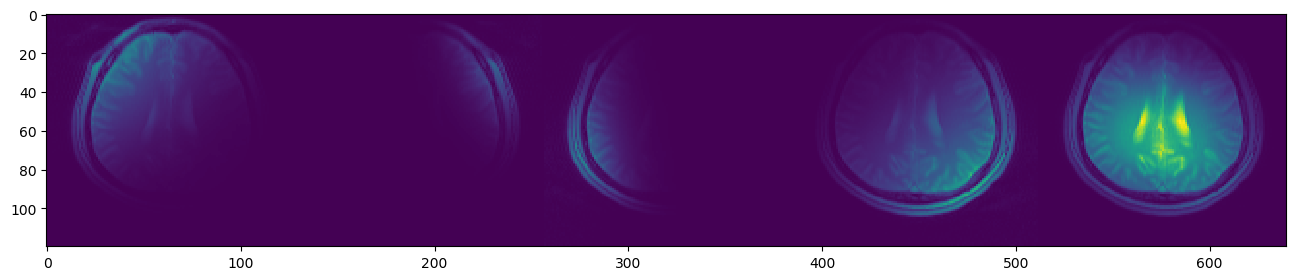

In [3]:
C = 5;                                # There are C = 5 coils
height, width = 120, 128              # Standard is 120, 128

# Load sensitivity maps
file = matopen("data/coil_sensitivity_map.mat");
coilSensitivityMaps = read(file, "coil_map");
close(file);

# Resize sensitivity maps
sm = zeros(height, width, C)
for i = 1:5
    sm[:,:,i] =  imresize(coilSensitivityMaps[:,:,i], (height, width));
end
coilSensitivityMaps = sm;

# Load coil images
file = matopen("data/brain_coil.mat");
coilScans = read(file, "brain_coil_tmp");
close(file);
cs = zeros(height, width, C)
for i = 1:5
    cs[:,:,i] =  imresize(coilScans[:,:,i], (height, width));
end
coilScans = cs;

## Load Shepp-Loagn phantom
# np = max(height, width)
# phantom = shepp_logan(np, highContrast=true);
# phantom = imresize(phantom, (height, width))
# # Apply sensitivity maps
# coilScans = coilSensitivityMaps.*phantom;

## Load image from folder
# img = load("413469fd-9354-400c-88e3-b29e7c711a05.jpg")
# img = Gray.(img)
# img = convert(Array{Float64}, img);
# img = imresize(img, (height, width))
## Apply sensitivity maps
# coilScans = coilSensitivityMaps.*img;

# Display sensitivity encoded images
imagedisp = reshape(coilScans, (height, width*C))
fig = figure(figsize=(16,16))
imshow(abs.(imagedisp[:,:]));

Sampled: 1038
Sampled/Full: 

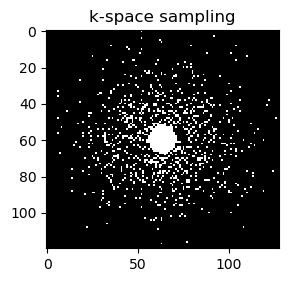

6.758%


In [4]:
## Simulate k-space sampling
# Number of samples
samp = 1000

# Indices of samples (possibly duplicated coordinates here)
ind = hcat(sampling(height),sampling(width));

# Intialise sampling matrix
P_Omega = zeros(height,width);

# Create mask for sampling middle of k-space
x = range(-height/2, height/2, length = height);
y = range(-width/2, width/2, length = width)';
mask = sqrt.(x.^2 .+ y.^2).< sqrt((height+width)/4);
P_Omega[mask] .= 1

# Finish sampling matrix
for i = 1: samp
    P_Omega[ind[i,1],ind[i,2]] = Int(1)
end

figure(figsize=(3,3))
imshow(P_Omega, cmap = "gray")
title("k-space sampling");

println("Sampled: ", sum(P_Omega .> 0));
println("Sampled/Full: ", round(sum(P_Omega .> 0)/(height*width)*100, digits = 3), "%");

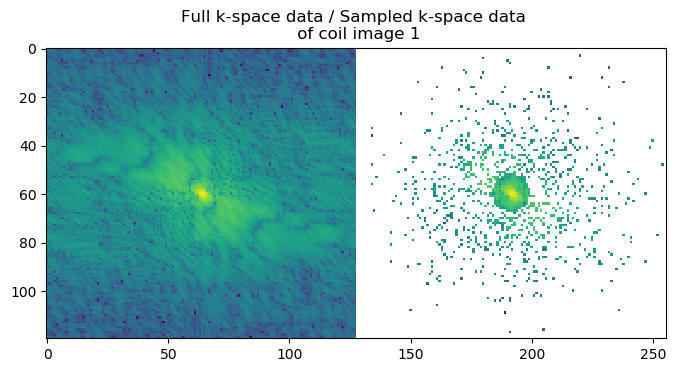

In [5]:
## Simulate K-Space data
# Full K-Space data of coil images
y_original = Phi_c(coilScans.+0*im); 

# Add some noise
n = 0*randn(height,width,C)

# Sample k-space data
y_data = P_Omega.*(y_original + n);

imagedisp = hcat(log.(abs.(y_original[:,:,1])),log.(abs.(y_data[:,:,1])));
fig = figure(figsize=(8,8));
imshow(abs.(imagedisp[:,:]));
title("Full k-space data / Sampled k-space data \n of coil image 1");


### Reconstruction

In [6]:
# Define hyperparameters 
α = 0.05;
β = 2*α;
ν = 2*α;

# Precompute inv(Lambda)
inv_Lambda = 1 ./(α*P_Omega.^2 .+(β + ν));

# Precompute pinv(S)
pinv_S = (1 ./sum(coilSensitivityMaps.^2, dims = 3)) .* coilSensitivityMaps;

In [7]:
## Initialise values  
y = y_data;
x = SoS(Phi_cH(y));
ds = zeros(height, width, C);
dpsi = ds;
bs = ds;
bpsi = ds;
Sx = coilSensitivityMaps.*x;

In [8]:
# Number of inner Bregman iterations 
nInner = 1; 

# Number of outer Bregman iterations 
maxIter = 100; 

# Alternatively can define threshold for stopping condition instead of nOuter
δ = 1e2;

#### Execute

In [14]:
err = y_data - F_Omega_c(Sx);
for nOut = 1:maxIter
    y = y + err;
    y = y + y_data - F_Omega_c(Sx);
    for nIn = 1:nInner
        ds = Phi_cH(apply_invLambda(Phi_c(α*F_Omega_cH(y) + β*Psi_cH(dpsi-bpsi) + ν*(Sx+bs))));
        dpsi = Jsoftshrink(Psi_c(ds) + bpsi, 1/β);
        bs = bs + Sx - ds;
        bpsi = bpsi + Psi_c(ds) - dpsi;
        x = apply_pinv_S(ds - bs);
        Sx = coilSensitivityMaps.*x
    end
    err = y_data - F_Omega_c(Sx);
    if norm(err) < δ
        println("Tolerance reached.")
        break;
    end
end
if norm(F_Omega_c(Sx)-y_data) > δ
    println("Max number of Iterations reached.")
end
print("||F_Omega_c(Sx)-y_data|| = ", norm(F_Omega_c(Sx)-y_data))

Max number of Iterations reached.
||F_Omega_c(Sx)-y_data|| = 1030.724082653531

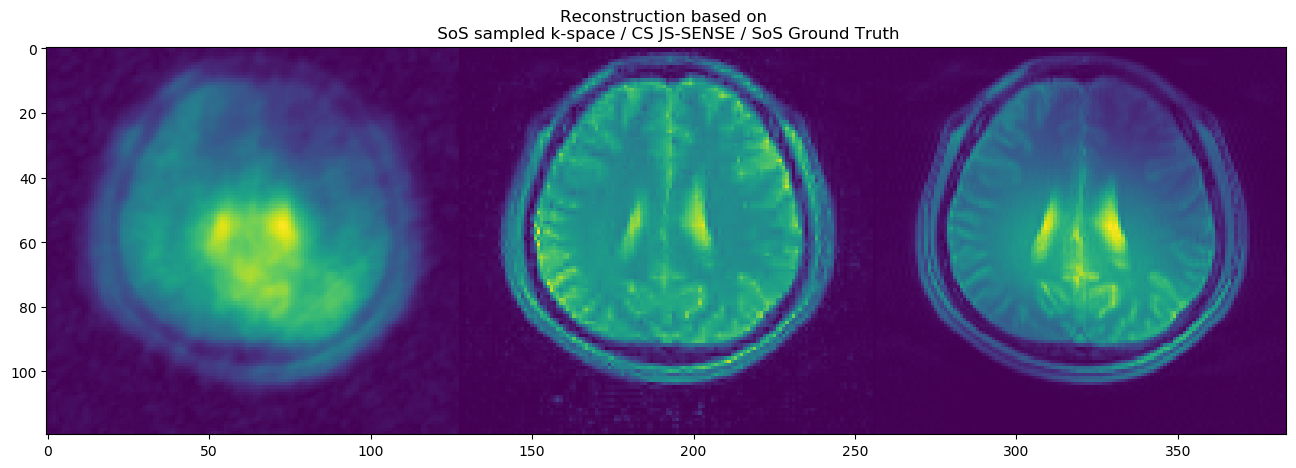

In [15]:
# Display sensitivity encoded images
imagedisp = hcat(scale(SoS(Phi_cH(y_data))[:,:,1]), scale(abs.((x))), scale(SoS(Phi_cH(y_original))[:,:,1]));
fig = figure(figsize=(16,16));
imshow(abs.(imagedisp[:,:]));
title("Reconstruction based on \n SoS sampled k-space / CS JS-SENSE / SoS Ground Truth");